## The University of Melbourne, School of Computing and Information Systems
# COMP90049 Introduction to Machine Learning, 2020 Semester 2
-----
## Project 1: Predicting stroke with Naive Bayes and K-NN
-----
###### Student Name(s): Haichao Song
###### Python version: 2.7.10
###### Submission deadline: 5 PM 11 Sep 2020

This iPython notebook is a template which you will use for your Project 1 submission. 

Marking will be applied on the functions that are defined in this notebook, and to your responses to the questions at the end of this notebook.

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find. 

In [1]:
import pandas as pd
import numpy as np
import re
import csv
import random
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from sklearn import metrics
from math import exp, sqrt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# This function should transform data into a usable format 
def preprocess(stroke_df, numeric=True, categorise=False, onehot=True, normalise=True):
    
    if numeric:
        stroke_df['gender'] = stroke_df['gender'].map({'Male': 1,'Female': 0})
        stroke_df['ever_married'] = stroke_df['ever_married'].map({'Yes': 1,'No': 0})
        stroke_df['Residence_type'] = stroke_df['Residence_type'].map({'Rural': 1,'Urban': 0})
        
    if onehot:
        stroke_df = one_hot_encoding(stroke_df, "smoking_status")
        stroke_df = one_hot_encoding(stroke_df, "work_type")
    
    if normalise:
        stroke_df = normalize(stroke_df, 'avg_glucose_level')
        stroke_df = normalize(stroke_df, 'bmi')
        stroke_df = normalize(stroke_df, 'age')
        
    if categorise:
        stroke_df = categorize(stroke_df, 'avg_glucose_level')
        stroke_df = categorize(stroke_df, 'bmi')
        stroke_df = categorize(stroke_df, 'age')
        
    cols = list(stroke_df.columns.values)
    cols.remove("stroke")
    cols.append("stroke")
    
    return stroke_df[cols]

def one_hot_encoding(data, column_name):
    new_df = data.copy()
    new_df = pd.get_dummies(new_df, prefix=column_name, columns=[column_name])
    return new_df

def normalize(data, column_name):
    new_df = data.copy()
    new_df[column_name]=(
        (new_df[column_name]       - new_df[column_name].min())/
        (new_df[column_name].max() - new_df[column_name].min())
    )
    
    return new_df

def categorize(data, column_name):
    new_df = data.copy()
    quan = [0, data[column_name].quantile(0.25), data[column_name].quantile(0.5), data[column_name].quantile(0.75), data[column_name].max()]
    new_df[column_name] = pd.cut(new_df[column_name], bins=quan, include_lowest=True, labels=['0', '1', '2','3'])
    return new_df

In [3]:
# This function should split a data set into a training set and hold-out test set      
def split_data(data, test_size=0.2, stratified=True):
    test_size = test_size
    train_size = 1 - test_size
    data_X, data_Y = data.iloc[:, 0:len(data.columns)-1], data.iloc[:, [-1]]
    
    if stratified:
        test_df, train_df = train_test_split(data, test_size=test_size, train_size=train_size, stratify=data_Y)
    else:
        test_df, train_df = train_test_split(data, test_size=test_size, train_size=train_size)
    
    # assume class is the last attribute
    X_test, Y_test = test_df.iloc[:, 0:len(test_df.columns)-1], test_df.iloc[:, [-1]]
    X_train, Y_train = train_df.iloc[:, 0:len(train_df.columns)-1], train_df.iloc[:, [-1]]
    return test_df, train_df

def split_xy(X_test, Y_test):
    X_test, Y_test = test_df.iloc[:, 0:len(test_df.columns)-1], test_df.iloc[:, [-1]]
    X_train, Y_train = train_df.iloc[:, 0:len(train_df.columns)-1], train_df.iloc[:, [-1]]
    return X_train, Y_train, X_test, Y_test

In [4]:
# This function should build a supervised NB model
def train(trainSet):
    p_y = {}
    p_xy = {}
    attri = []
    
    for i in range(len(trainSet[0][:-1])):
        attri.append([])
    
    for instance in trainSet:
        if instance[-1] not in p_y:
            p_y[instance[-1]] = 1
            p_xy[instance[-1]] = []
            for feature in range(len(instance[:-1])):
                attribute = instance[feature]
                p_xy[instance[-1]].append({})
        else:
            p_y[instance[-1]] += 1
          
    for instance in trainSet:
        label = instance[-1]
        for feature in range(len(instance[:-1])):
            if instance[feature] not in attri[feature]:
                attri[feature].append(instance[feature])
            if instance[feature] not in p_xy[label][feature].keys():
                p_xy[label][feature][instance[feature]] = 1
            else:
                p_xy[label][feature][instance[feature]] += 1 

    return p_y, p_xy, len(trainSet), attri

In [5]:
# This function should predict the class for an instance or a set of instances, based on a trained model 
def predict(model, testData):
    max_prob = -sys.maxsize-1
    max_label = None
    alpha = 1
    p_y, p_xy, total, attri = model
    
    def getProb(label, priors):
        likelihoods = 0
        for i in range(len(testData)):
            attribute = testData[i]
            M = len(attri[i])
            
            if (attribute not in p_xy[label][i].keys()):
                likelihood = np.log((0+alpha)/(p_y[label]+alpha*M))
            else:
                likelihood = np.log((p_xy[label][i][attribute]+alpha)/(p_y[label]+alpha*M))
            likelihoods += likelihood
        return np.log(priors) + likelihoods
            
    for label in p_y.keys():
        priors = round(p_y[label]/total, 3)
        currentProb = getProb(label,priors)
        if (currentProb > max_prob):
            max_prob = currentProb
            max_label = label

    return max_label

In [6]:
# This function should evaluate a set of predictions in terms of accuracy
def evaluate(true, pred):
    confusion_matrix = metrics.confusion_matrix(true, pred)
    accuracy = metrics.accuracy_score(true, pred)
    PRF = metrics.precision_recall_fscore_support(true, pred, average='macro')
    return confusion_matrix, accuracy, PRF

## Questions (you may respond in a cell or cells below):

You should respond to questions 1-4. In question 2 (b) you can choose between two options. A response to a question should take about 100--200 words, and make reference to the data wherever possible.

### Question 1: Data exploration

- a) Explore the data and summarise different aspects of the data. Can you see any interesting characteristic in features, classes or categories? What is the main issue with the data? Considering the issue, how would the Naive Bayes classifier work on this data? Discuss your answer based on the Naive Bayes' formulation.
- b) Is accuracy an appropriate metric to evaluate the models created for this data? Justify your answer. Explain which metric(s) would be more appropriate, and contrast their utility against accuracy. [no programming required]



### Q1 a)

#### Read data

In [7]:
stroke_df = pd.read_csv('stroke_update.csv')
stroke_df

,avg_glucose_level,bmi,age,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke
0,137.45,26.0,53,Male,0,0,Yes,Self-employed,Rural,smokes,0
1,56.85,24.4,44,Female,0,0,Yes,Private,Rural,never smoked,0
2,87.79,41.1,49,Female,0,0,No,Private,Urban,never smoked,0
3,94.82,22.9,28,Female,0,0,No,Private,Urban,never smoked,0
4,96.80,29.6,73,Male,0,0,Yes,Private,Urban,formerly smoked,0
...,...,...,...,...,...,...,...,...,...,...,...
2735,88.29,36.0,79,Male,0,1,Yes,Self-employed,Urban,never smoked,1
2736,93.38,26.7,76,Male,0,0,Yes,Self-employed,Rural,formerly smoked,1
2737,83.27,32.9,56,Female,0,0,Yes,Private,Rural,smokes,1
2738,75.91,26.7,80,Female,0,0,Yes,Self-employed,Urban,never smoked,1


#### Check missing data

In [8]:
missing = stroke_df.isnull().sum()
missing

avg_glucose_level    0
bmi                  0
age                  0
gender               0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
smoking_status       0
stroke               0
dtype: int64

####  Change categorial date to numerical data

In [9]:
stroke_df['gender'] = stroke_df['gender'].map({'Male': 1,'Female': 0})
stroke_df['ever_married'] = stroke_df['ever_married'].map({'Yes': 1,'No': 0})
stroke_df['work_type'] = stroke_df['work_type'].map({'Govt_job': 3,'Private': 2, 'Self-employed': 1, 'children': 0})
stroke_df['Residence_type'] = stroke_df['Residence_type'].map({'Rural': 1,'Urban': 0})
stroke_df['smoking_status'] = stroke_df['smoking_status'].map({'smokes': 2,'formerly smoked': 1, 'never smoked': 0})

In [10]:
stroke_df

,avg_glucose_level,bmi,age,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke
0,137.45,26.0,53,1,0,0,1,1.0,1,2,0
1,56.85,24.4,44,0,0,0,1,2.0,1,0,0
2,87.79,41.1,49,0,0,0,0,2.0,0,0,0
3,94.82,22.9,28,0,0,0,0,2.0,0,0,0
4,96.80,29.6,73,1,0,0,1,2.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2735,88.29,36.0,79,1,0,1,1,1.0,0,0,1
2736,93.38,26.7,76,1,0,0,1,1.0,1,1,1
2737,83.27,32.9,56,0,0,0,1,2.0,1,2,1
2738,75.91,26.7,80,0,0,0,1,1.0,0,0,1


#### Check distribution

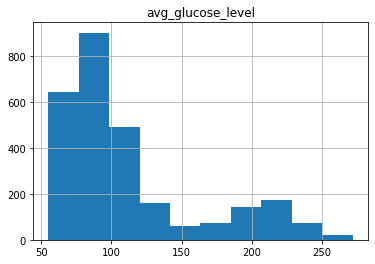

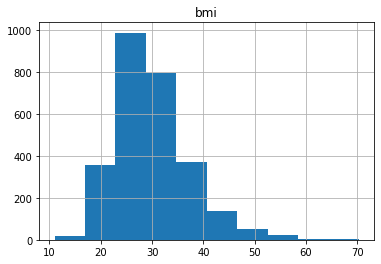

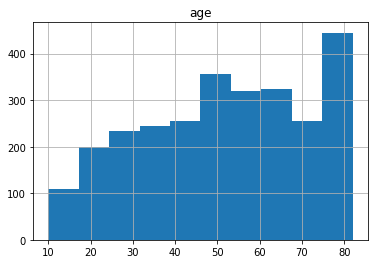

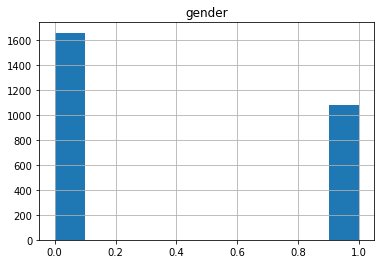

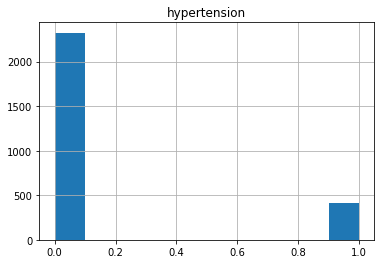

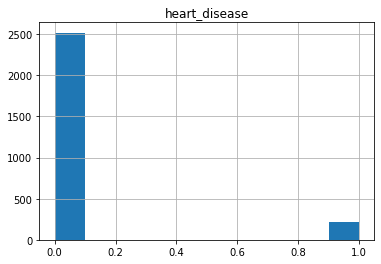

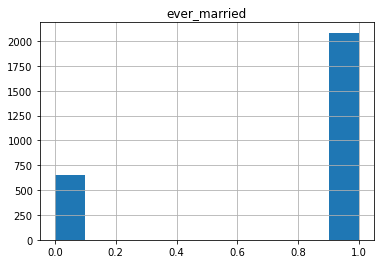

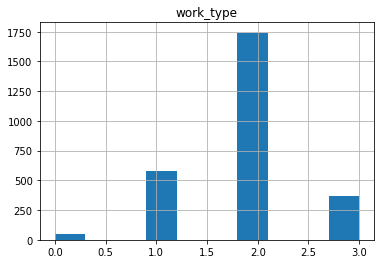

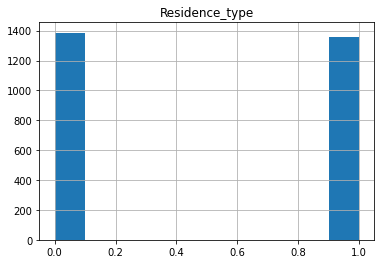

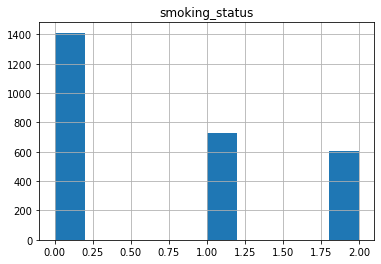

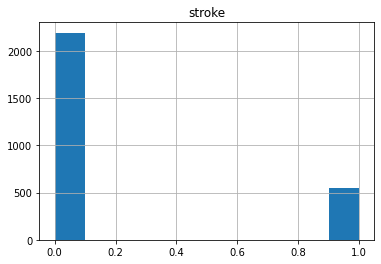

In [11]:
for attribute in stroke_df:
    stroke_df.hist(column = attribute)
    stroke_df[attribute].value_counts() / stroke_df[attribute].count()

In [12]:
stroke_corr = stroke_df.corr()
stroke_corr

,avg_glucose_level,bmi,age,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke
avg_glucose_level,1.000000,0.222221,0.267942,0.048000,0.153631,0.199533,0.140880,-0.040831,0.010321,0.005995,0.195651
bmi,0.222221,1.000000,0.073568,0.015591,0.120742,0.015180,0.130180,0.070446,-0.015028,0.028255,-0.010339
age,0.267942,0.073568,1.000000,0.062799,0.299846,0.261760,0.525890,-0.053246,-0.016144,0.031045,0.431107
gender,0.048000,0.015591,0.062799,1.000000,0.039282,0.102391,0.051499,-0.037602,-0.021190,0.114395,0.035096
hypertension,0.153631,0.120742,0.299846,0.039282,1.000000,0.127824,0.141752,-0.028818,0.000873,0.005711,0.192728
heart_disease,0.199533,0.015180,0.261760,0.102391,0.127824,1.000000,0.100569,-0.008238,0.006143,0.085334,0.256132
ever_married,0.140880,0.130180,0.525890,0.051499,0.141752,0.100569,1.000000,0.053636,-0.027941,0.064902,0.158306
work_type,-0.040831,0.070446,-0.053246,-0.037602,-0.028818,-0.008238,0.053636,1.000000,-0.005090,0.042342,-0.061916
Residence_type,0.010321,-0.015028,-0.016144,-0.021190,0.000873,0.006143,-0.027941,-0.005090,1.000000,0.003433,-0.003285
smoking_status,0.005995,0.028255,0.031045,0.114395,0.005711,0.085334,0.064902,0.042342,0.003433,1.000000,0.019712


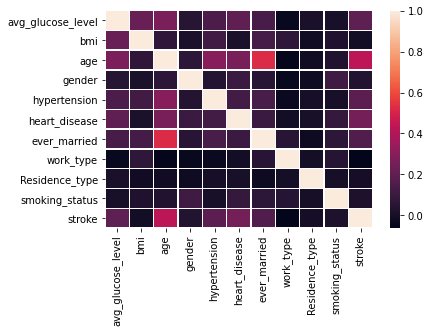

In [13]:
plt.figure()
sns.heatmap(stroke_corr, linewidths=.5)
plt.show()

- The dataset is completed and there is no missing value in the dataset.
- Moreover, there are several issues in the dataset:
    - First, only about 20% percent of instances in the dataset get stroke and the rest 80% are not. The bias may influence the result accuracy since most of instances trained have no stroke. A model predicts all instances with false will have 80% accuracy 
    - Secondly, from the correlation table and the heatmap we find there is a high correlation between ever_married and age. It makes sense. Young people are unlikely to get married compared to old people. However, naive bayes classifier assumes features are independent. The influence of married and age will be doubled if these two features are highly correlated beacause they have a large probability to have the same value and we consider both of them. Therefore, the accuracy will be influenced by high correlated features.

### 1 b)

Accuracy is not an appropriate metric to evaluate the models created for this data, because only 20% of instances in the dataset have strokes and the rest 80% have no stroke. A model predicts only no stroke will get 80% accuracy, which is high but useless.
We have more appropriate metrics including precision, recall and f1 score. Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. Recall is the ratio of correctly predicted positive observations to the all observations in actual class. A high precision with low recall score means we predict no stroke instances to have stroke and conversely a high recall but low precision means we predict stroke instances to have no stroke. Therefore, we use f1 score to measure the weight between precision and recall. It balances precision and recall and shows effect of the model.

### Question 2: Naive Bayes concepts and formulation

- a) Explain the independence assumption underlying Naive Bayes. What are the advantages and disadvantages of this assumption? Elaborate your answers using the features of the provided data. [no programming required]
- b) Implement the Naive Bayes classifier. You need to decide how you are going to apply Naive Bayes for nominal and numeric attributes. You can combine both Gaussian and Categorical Naive Bayes (option 1) or just using Categorical Naive Bayes (option 2). Explain your decision. For Categorical Naive Bayes, you can choose either epsilon or Laplace smoothing for this calculation. Evaluate the classifier using accuracy and appropriate metric(s) on test data. Explain your observations on how the classifiers have performed based on the metric(s). Discuss the performance of the classifiers in comparison with the Zero-R baseline.
- c) Explain the difference between epsilon and Laplace smoothing. [no programming required]

### Q2 a)

The conditional independence assumption: Conditioned on the class $y$, the features $x_1, x_2,...,x_m$ are assumed to be independent:
<center> $P(x_1, x_2,...,x_m|y) \propto P(x_1|y) \ \ast P(x_2|y) \ \ast ... \ast P(x_m|y) \ \ast P(y)$ </center>

In this dataframe, the assumption is: conditioned on "stroke", all of features "avg_glucose_level", "bmi", "age",	"gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "smoking_status" are assumed to be independent.

- Advantages: The key advantage of conditional independence assumption is it reduces the curse of dimensionality. For 10 binary features, there will be 1024 possible feature configrations and we need to estimate that much of likelihoods for each class. By assuming the conditional independence we reduce the likelihoods from 1024 to 8. Another advantage is that conditional independence allows inference about new feature configration.  Even if a particular combination of feature values has not been observed yet, assuming conditional independence allows inference of the likelihood of the feature configuration from the marginal likelihoods of the individual feature values, thereby enabling computing the posterior class probabilities
- Disadvantage: conditional independence between different features rarely holds in real-world environments. Therefore, we need more analysis before applying data to NB model, in order to reduce this negative influence on performance and increase the robustness of models

### Q2 b)

In [14]:
strokeList = ['1','0']
[precision, recall, f1] = [0,0,0]
[accuracy, currentAccuracy] = [0,0]
stroke_nb = pd.read_csv('stroke_update.csv')
stroke_nb = preprocess(stroke_nb, categorise=True).applymap(str) 
accuracies = 0
testTimes = 1

def feature_pattern(data, y):
    feature = []
    
    for i in range(18):
        feature.append({}) 
    
    for instance in data:
        label = instance[-1]
        for i in range(len(instance[:-1])):
            attribute = instance[i]
            if (label == y):
                if attribute in feature[i].keys():
                    feature[i][attribute]+=1
                else:
                    feature[i][attribute]=1            
    return feature
    
def evaluate_accuracy():
    max_label = None
    true_label = 0
    for feature in range(len(testSet)):
        max_label = predict(train(trainSet), testSet[feature][:-1])
        if (max_label == testSet[feature][-1]):
            true_label += 1
        evaluate_list.append([testSet[feature][-1], max_label])
    accuracy = true_label / len(testSet)
        
    return accuracy

def evaluate_PRF1():
    [precisions, recalls, f1s] = [0,0,0]
    [tps, fps, fns] = [0,0,0]

    for stroke in strokeList:
        [tp, fp, fn] = [0,0,0]
        
        for evaluate in evaluate_list:
            [actual, prediction] = [evaluate[0], evaluate[1]]
            if (actual == stroke and prediction == stroke):
                tp += 1
            if (actual != stroke and prediction == stroke):
                fp += 1
            if (actual == stroke and prediction != stroke):
                fn += 1
        
        if ((tp + fp) == 0 or (tp + fn) == 0 or (tp + fp + fn) == 0):
            precision = 0
            recall = 0
            f1 = 0
        else:
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            if (precision+recall == 0):
                f1 = 0
            else:
                f1 = (2 * precision * recall) / (precision + recall)
        tps += tp
        fps += fp
        fns += fn

        print( '---------------', stroke, '---------------' )
        print('Precision', precision)
        print('Recall', recall)
        print('f1',f1)
            
        precisions += precision
        recalls += recall
        f1s += f1
    
    precision_macro = precisions / len(strokeList)
    recall_macro = recalls / len(strokeList)
    f1_macro = (2 * precision_macro * recall_macro) / (precision_macro + recall_macro)
    print('------------------------------')  
    return [precision_macro, recall_macro, f1_macro]

for i in range(testTimes):
    trainSet, testSet = split_data(stroke_nb)
    trainSet = trainSet.values.tolist()
    testSet = testSet.values.tolist()
    evaluate_list = []
    currentAccuracy = evaluate_accuracy()
    accuracy += currentAccuracy
    
for stroke in strokeList:
    feature_pattern(stroke_nb, stroke)
    
[precision, recall, f1] = evaluate_PRF1()
    
print('Accuracy(hold-out)', accuracy/testTimes)
print('Precision(macro-average)', precision)
print('Recall(macro-average)', recall) 
print('f1(macro-average)', f1)

--------------- 1 ---------------
Precision 0.47706422018348627
Recall 0.4727272727272727
f1 0.4748858447488585
--------------- 0 ---------------
Precision 0.8678815489749431
Recall 0.8698630136986302
f1 0.8688711516533637
------------------------------
Accuracy(hold-out) 0.7901459854014599
Precision(macro-average) 0.6724728845792147
Recall(macro-average) 0.6712951432129515
f1(macro-average) 0.6718834977821792


In [15]:
def zeroR_evaluation():
    maximum = 0
    [precisions, recalls, f1s] = [0,0,0]
    [tps, fps, fns] = [0,0,0]
    [precision, recall, f1] = [0,0,0]

#     testSet, trainSet = split_data(stroke_nb)
    labels = train(trainSet)[0]
    
    for each_label in labels.keys():
        if(labels[each_label] > maximum):
            maximum = labels[each_label]
            predict = each_label
    
    for stroke in strokeList:
        [tp, fp, fn] = [0,0,0]
        for index in range(len(testSet)):
            if ((testSet[index][-1]) == stroke and predict == stroke):
                tp += 1
            if ((testSet[index][-1]) != stroke and predict == stroke):
                fp += 1
            if ((testSet[index][-1]) == stroke and predict != stroke):
                fn += 1
        if ((tp+fp) == 0 or (tp+fn) == 0 or (tp+fp+fn) == 0):
            precision = 0
            recall = 0
            f1 = 0
        else:
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
        if (precision+recall == 0):
            f1 = 0
        else:
            f1 = (2*precision*recall)/(precision+recall)
        tps+=tp
        fps+=fp
        fns+=fn
    
        # seperately for each class
        print( '---------------', stroke, '---------------' )
        print('Precision', precision)
        print('Recall', recall)
        print('f1',f1)
        
        precisions += precision
        recalls += recall
        f1s += f1
    
    precision_macro = precisions / len(strokeList)
    recall_macro = recalls / len(strokeList)
    f1_macro = (2 * precision_macro * recall_macro) / (precision_macro + recall_macro)
    
    print('------------------------------')
    
    print('Accuracy(hold-out)', accuracy/testTimes)
    print('Precision(macro-average)', precision_macro)
    print('Recall(macro-average)', recall_macro) 
    print('f1(macro-average)', f1_macro)
    return 

zeroR_evaluation()

--------------- 1 ---------------
Precision 0
Recall 0
f1 0
--------------- 0 ---------------
Precision 0.7992700729927007
Recall 1.0
f1 0.8884381338742393
------------------------------
Accuracy(hold-out) 0.7901459854014599
Precision(macro-average) 0.39963503649635035
Recall(macro-average) 0.5
f1(macro-average) 0.44421906693711966


- In the Naive Bayes classifier, I choose to use categorical naive bayes classifier with Laplace smoothing. 
- In this case Laplace smoothing performs better than Epsilon because there are many 0 in naive bayes calculations and epsilon smoothing will be influenced by 0 probability. Epsilon smoothing counts for unknow information while ignore some known information but Laplace smoothing does not throw away any known infomation.
- The classifier scores 0.68884 on precision and 0.68495 on recall, which are pretty close. It's ability to correctly classify positive instance is the same as its ability to correctly classify negative instance. This result shows the classification is balanced.
- By comparing the matrics with zero R baseline. We can see the accuracy does not show difference, but f1 score clearly shows zero R is a bad classifier. Both of two classifier have 80% accuracy because 80% of instances in data have no stroke. However, zero R baseline has only 0.44 f1 score, much lower than naive bayes. The result proves accuracy is not an appropriate metric to evaluate the models but f1 score is.

### Q2 c)

Both epsilon and Laplace smoothing aim to solve the situation that probability is 0, when we have unseen attributes after training.

- Different way to solve the problem. Epsilon smoothing replaces the 0 probability with a small decimal number in both training and testing phases.  Laplace smoothing adds an additional $\alpha$ to numerator and *distinct value of features* * $\alpha$ to denominator in the training phase. 
- Different influence on result. If there is no 0 probability in training phase, epsilon smoothing does not influence the result as no modification happens. However, laplace smoothing changes the result as we modify the posterior probability no matter 0 probability happens or not. However, in using epsilon smoothing, more 0 we get in probability, smaller probability we will get in the result. The reason is we ignore the situation that it is really impossible according to the training set, while laplace smoothing does not have this influence.
- Difference in monotonicity. Epsilon smoothing maintains monotonicity but laplace smoothing does not maintain monotonicity.

### Question 3: Model Comparison
- a) Implement the K-NN classifier, and find the optimal value for K. 
- b) Based on the obtained value for K in question 4 (a), evaluate the classifier using accuracy and chosen metric(s) on test data. Explain your observations on how the classifiers have performed based on the metric(s). Discuss the performance of the classifiers in comparison with the Zero-R baseline.
- c) Is K-NN sensitive to imbalanced data? Justify your answer. [no programming required]
- d) Compare the classifiers (Naive Bayes and K-NN) based on metrics' results. Provide a comparatory discussion on the results. [no programming required]

### Q3 a)

#### Preprocess

In [16]:
stroke_knn = pd.read_csv('stroke_update.csv')
stroke_knn

,avg_glucose_level,bmi,age,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke
0,137.45,26.0,53,Male,0,0,Yes,Self-employed,Rural,smokes,0
1,56.85,24.4,44,Female,0,0,Yes,Private,Rural,never smoked,0
2,87.79,41.1,49,Female,0,0,No,Private,Urban,never smoked,0
3,94.82,22.9,28,Female,0,0,No,Private,Urban,never smoked,0
4,96.80,29.6,73,Male,0,0,Yes,Private,Urban,formerly smoked,0
...,...,...,...,...,...,...,...,...,...,...,...
2735,88.29,36.0,79,Male,0,1,Yes,Self-employed,Urban,never smoked,1
2736,93.38,26.7,76,Male,0,0,Yes,Self-employed,Rural,formerly smoked,1
2737,83.27,32.9,56,Female,0,0,Yes,Private,Rural,smokes,1
2738,75.91,26.7,80,Female,0,0,Yes,Self-employed,Urban,never smoked,1


In [17]:
stroke_knn = preprocess(stroke_knn)
stroke_knn

,avg_glucose_level,bmi,age,gender,hypertension,heart_disease,ever_married,Residence_type,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,stroke
0,0.380381,0.252951,0.597222,1,0,0,1,1,0,0,1,0,0,0,1,0,0
1,0.008490,0.225970,0.472222,0,0,0,1,1,0,1,0,0,0,1,0,0,0
2,0.151248,0.507589,0.541667,0,0,0,0,0,0,1,0,0,0,1,0,0,0
3,0.183685,0.200675,0.250000,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,0.192821,0.313659,0.875000,1,0,0,1,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2735,0.153555,0.421585,0.958333,1,0,1,1,0,0,1,0,0,0,0,1,0,1
2736,0.177041,0.264755,0.916667,1,0,0,1,1,1,0,0,0,0,0,1,0,1
2737,0.130393,0.369309,0.638889,0,0,0,1,1,0,0,1,0,0,1,0,0,1
2738,0.096433,0.264755,0.972222,0,0,0,1,0,0,1,0,0,0,0,1,0,1


In [18]:
def split_data(data, k):
    kf = StratifiedKFold(n_splits=k)
    data_X, data_Y = data.iloc[:, 0:len(data.columns)-1], data.iloc[:, [-1]]
    
    for train_index, test_index in kf.split(data_X, data_Y):
        X_train, Y_train = data_X.iloc[train_index,:], data_Y.iloc[train_index,:]
        X_test,  Y_test  = data_X.iloc[test_index, :], data_Y.iloc[test_index, :]
        yield X_train, Y_train, X_test, Y_test

#### Optimal k for euclidean distance

In [27]:
x = []
accuracies = []
precisions = []
recalls = []
f1s = []
k_range = 100

for k in range(1, k_range):
    print(k)
    classifier = KNeighborsClassifier(n_neighbors=k, metric='euclidean', weights='distance')
    x.append(k)
    accuracy, precision, recall, f1 = 0, 0, 0, 0
    i = 0
    for X_train, Y_train, X_test, Y_test in split_data(stroke_knn, k=10):        
        classifier.fit(X_train, np.ravel(Y_train))
        prediction = classifier.predict(X_test)
        _, accu, PRF = evaluate(np.ravel(Y_test), prediction)
        accuracy += accu
        precision += PRF[0]
        recall += PRF[1]
        f1 += PRF[2]
        i += 1
    
    accuracy /= i
    precision /= i
    recall /= i
    f1 /= i
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


73


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


74


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


75


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


76


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


77


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


78


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


79


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


80


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


81


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


82


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


83
84


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


85


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


86


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


87


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


88


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


89
90


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


91


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


92


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


93


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


94


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


96


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


97


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


98


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


99


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


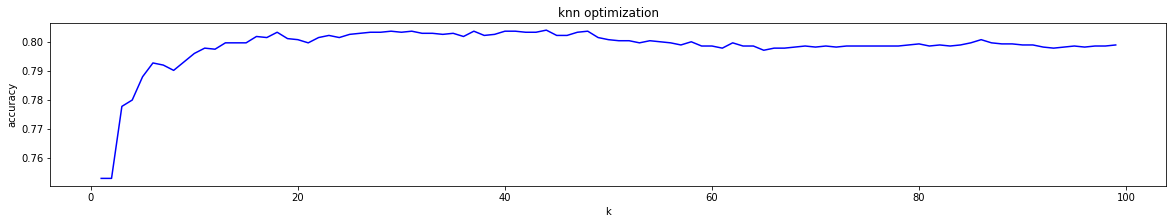

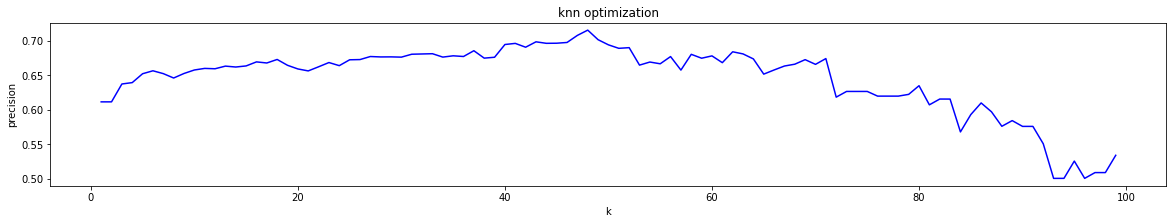

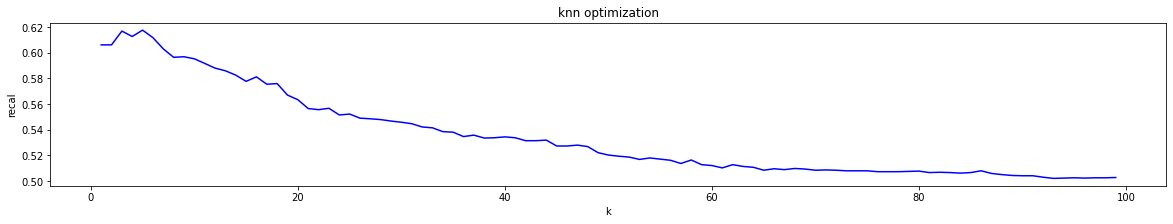

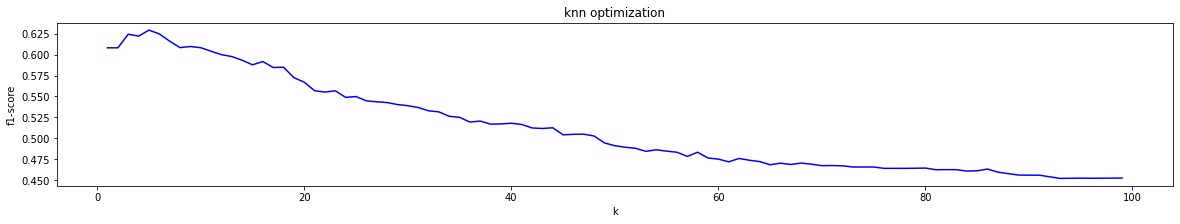

In [20]:
plt.figure(figsize=(20, 3))
plt.plot(x, accuracies, 'b-')
plt.xlabel("k")
plt.ylabel("accuracy")
plt.title("knn optimization")
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(x, precisions, 'b-')
plt.xlabel("k")
plt.ylabel("precision")
plt.title("knn optimization")
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(x, recalls, 'b-')
plt.xlabel("k")
plt.ylabel("recal")
plt.title("knn optimization")
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(x, f1s, 'b-')
plt.xlabel("k")
plt.ylabel("f1-score")
plt.title("knn optimization")
plt.show()

In [21]:
print("k", x[np.argmax(accuracies)], "maximize accuracy:", accuracies[np.argmax(accuracies)])
print("k", x[np.argmax(precisions)], "maximize precision:", precisions[np.argmax(precisions)])
print("k", x[np.argmax(recalls)], "maximize recall ", recalls[np.argmax(recalls)])
print("k", x[np.argmax(f1s)], "maximize f1-score :", f1s[np.argmax(f1s)])

k 44 maximize accuracy: 0.8040145985401461
k 48 maximize precision: 0.715114476120789
k 5 maximize recall  0.617695101701951
k 5 maximize f1-score : 0.6290799995502072


#### Optimal k for manhattan distance

In [22]:
x = []
accuracies = []
precisions = []
recalls = []
f1s = []
k_range = 100

for k in range(1, k_range):
    print(k)
    classifier = KNeighborsClassifier(n_neighbors=k, metric='manhattan', weights='distance')
    x.append(k)
    accuracy, precision, recall, f1 = 0, 0, 0, 0
    i = 0
    for X_train, Y_train, X_test, Y_test in split_data(stroke_knn, k=10):        
        classifier.fit(X_train, np.ravel(Y_train))
        prediction = classifier.predict(X_test)
        _, accu, PRF = evaluate(np.ravel(Y_test), prediction)
        accuracy += accu
        precision += PRF[0]
        recall += PRF[1]
        f1 += PRF[2]
        i += 1
    
    accuracy /= i
    precision /= i
    recall /= i
    f1 /= i
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


77
78


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


79


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


80


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


81


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


82


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


83


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


84


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


85


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


86


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


87


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


88


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


89


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


90


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


91


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


92


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


93


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


94


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


96


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


97


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


98


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


99


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


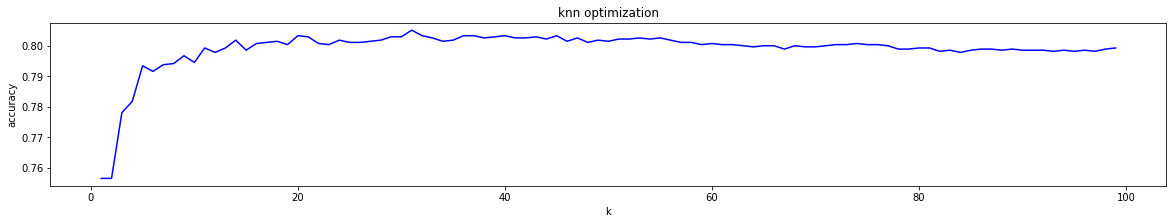

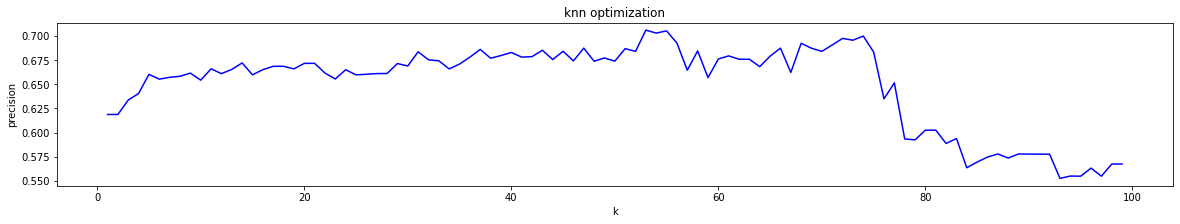

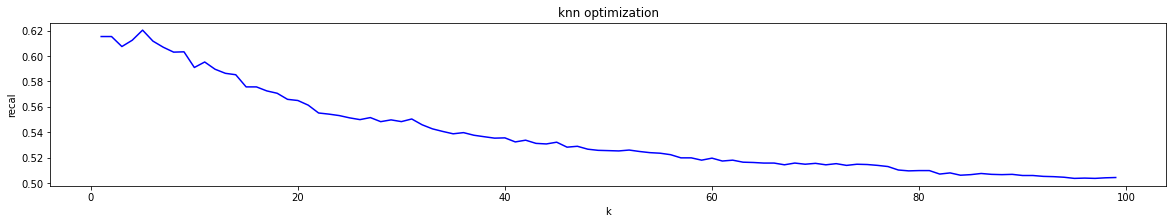

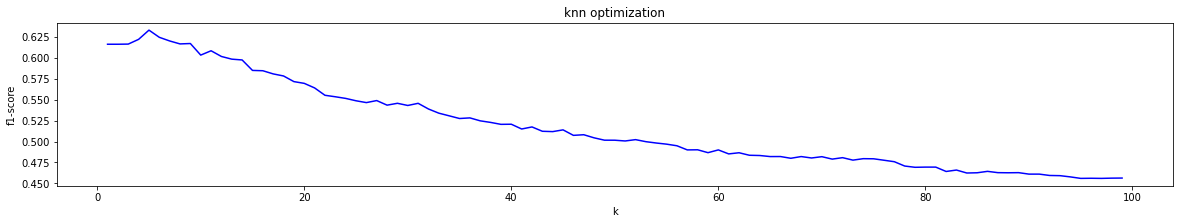

In [23]:
plt.figure(figsize=(20, 3))
plt.plot(x, accuracies, 'b-')
plt.xlabel("k")
plt.ylabel("accuracy")
plt.title("knn optimization")
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(x, precisions, 'b-')
plt.xlabel("k")
plt.ylabel("precision")
plt.title("knn optimization")
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(x, recalls, 'b-')
plt.xlabel("k")
plt.ylabel("recal")
plt.title("knn optimization")
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(x, f1s, 'b-')
plt.xlabel("k")
plt.ylabel("f1-score")
plt.title("knn optimization")
plt.show()

In [24]:
print("k", x[np.argmax(accuracies)], "maximize accuracy:", accuracies[np.argmax(accuracies)])
print("k", x[np.argmax(precisions)], "maximize precision:", precisions[np.argmax(precisions)])
print("k", x[np.argmax(recalls)], "maximize recall ", recalls[np.argmax(recalls)])
print("k", x[np.argmax(f1s)], "maximize f1-score :", f1s[np.argmax(f1s)])

k 31 maximize accuracy: 0.8051094890510949
k 53 maximize precision: 0.7060380847269142
k 5 maximize recall  0.6204410543794106
k 5 maximize f1-score : 0.6331551932391863


### 3 b)

#### zero-R baseline

In [25]:
best_k = [5, 5]
three_model_f1 = [0, 0, 0]
three_model_accuracy = [0, 0, 0]
three_model_precision = [0, 0, 0]
three_model_recall = [0, 0, 0]
zero_r_classifier = DummyClassifier(strategy="most_frequent")
distances = ['euclidean', 'manhattan']

i = 0
for X_train, Y_train, X_test, Y_test in split_data(stroke_knn, 10):  
    print(i)
    zero_r_classifier.fit(X_train, Y_train)
    prediction = zero_r_classifier.predict(X_test)
    _, accu, PRM = evaluate(Y_test, prediction)
    three_model_accuracy[0] += accu
    three_model_precision[0] += PRM[0]
    three_model_recall[0] += PRM[1]
    three_model_f1[0] += PRM[2]
    i += 1
    
    for j, distance in enumerate(distances):
        knn_classifier = KNeighborsClassifier(n_neighbors=best_k[j], metric=distances[j], weights='distance')
        knn_classifier.fit(X_train, np.ravel(Y_train))
        prediction = knn_classifier.predict(X_test)
        _, accu, PRM = evaluate(np.ravel(Y_test), prediction)
        three_model_accuracy[j+1] += accu
        three_model_precision[j+1] += PRM[0]
        three_model_recall[j+1] += PRM[1]
        three_model_f1[j+1] += PRM[2]
        
for j in range(len(three_model_f1)):
    three_model_accuracy[j] /= i
    three_model_precision[j] /= i
    three_model_recall[j] /= i
    three_model_f1[j] /= i

0
1
2


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classificat

3
4
5


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


6
7


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8
9


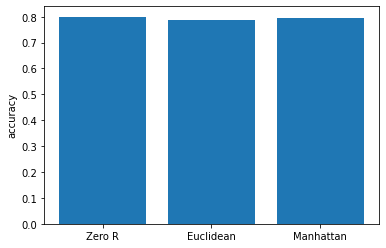

[0.8, 0.7879562043795622, 0.7934306569343066]


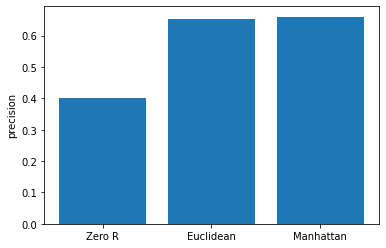

[0.4, 0.6519479412791416, 0.6602587214181931]


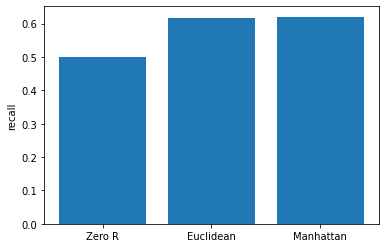

[0.5, 0.617695101701951, 0.6204410543794106]


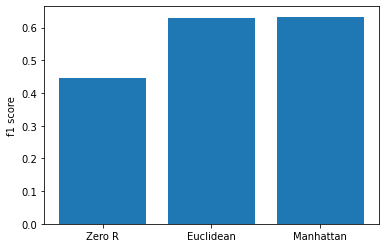

[0.4444440794606269, 0.6290799995502072, 0.6331551932391863]


In [26]:
plt.bar(x = range(0, len(three_model_accuracy)), height = three_model_accuracy, tick_label = ["Zero R", "Euclidean", "Manhattan"])
plt.ylabel("accuracy")
plt.show()
print(three_model_accuracy)

plt.bar(x = range(0, len(three_model_precision)), height = three_model_precision, tick_label = ["Zero R", "Euclidean", "Manhattan"])
plt.ylabel("precision")
plt.show()
print(three_model_precision)

plt.bar(x = range(0, len(three_model_recall)), height = three_model_recall, tick_label = ["Zero R", "Euclidean", "Manhattan"])
plt.ylabel("recall")
plt.show()
print(three_model_recall)

plt.bar(x = range(0, len(three_model_f1)), height = three_model_f1, tick_label = ["Zero R", "Euclidean", "Manhattan"])
plt.ylabel("f1 score")
plt.show()
print(three_model_f1)

- From the diagram and the results from 3 a), I will choose manhattan distance with k = 5 knn classifier and the f1 score as accuracy metric on test data. As I mentioned above, we choose f1 score metric to eveluate models and f1 have highest score for both euclidean and manhattan distance classifiers when k = 5. The manhattan distance knn classifier has slightly higher scores in all precision, recall and f1 compared to euclidean distance. The reason is different scales in features cause different scales of influence to the models and manhattan distance reduces its impact in calculation.
- Compared to Zero-R baseline, except three models have the same accuracy, knn classifiers performs much better in precision, recall and f1 score. The most largest improvement is in presicion, which means knn classifiers predict well in positive stroke instances.

### Q3 c)

- By comparing the matrics scores of naive bayes classifier and knn classifier, we can see naive bayes has better scores in all four metrics. 
- Naive bayes classifier also has balanced prediction in precision and recall while knn classifier shows a higher precision score compares to recall, means knn predicts positive instances better than negative ones. 
- The reason might be naive bayes assumes independent features and in this dataset most features have no correlations, while knn does not know which features is more important in prediction. These not important features influence the prediction and mislead to incorrect results.
- Considering the efficiency, naive bayes classifier has O(1) time complexity and knn classifier has O(n). Knn classifier also has higher space complexity since it needs to store all test instances. However, the dataset is small so the practical difference in time and space will not be large.
- As a result, naive bayes classifier is a better classifier to evaluate this dataset.